# Kaggle Titanic Competition

---
**Note:**

This notebook runs on Ubuntu 22.04 LTS with **Python 3.9.12**. There is no GPU support.

# Imports

## Package imports
Import all packages needed to run your code here. 

You can install packages by running a cell with the following code: `!pip install <LIBRARY_NAME>`

In [1]:
import os
from pathlib import Path
base_dir_joblib_temp_folder = "./~joblib"
Path(base_dir_joblib_temp_folder).mkdir(exist_ok=True, parents=True)
os.environ["JOBLIB_TEMP_FOLDER"] = str(base_dir_joblib_temp_folder)

In [2]:
# !pip install xgboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
pd.set_option('display.max_rows', 100); pd.set_option('display.max_columns', 200); 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data Import

In [3]:
train_df = pd.read_csv("data/train.csv", index_col='PassengerId')
test_df = pd.read_csv("data/test.csv", index_col='PassengerId')

## Data Analysis

In [4]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Describe

In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [6]:
train_df.describe(include='O').T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


### Cross- correlation table

<AxesSubplot:>

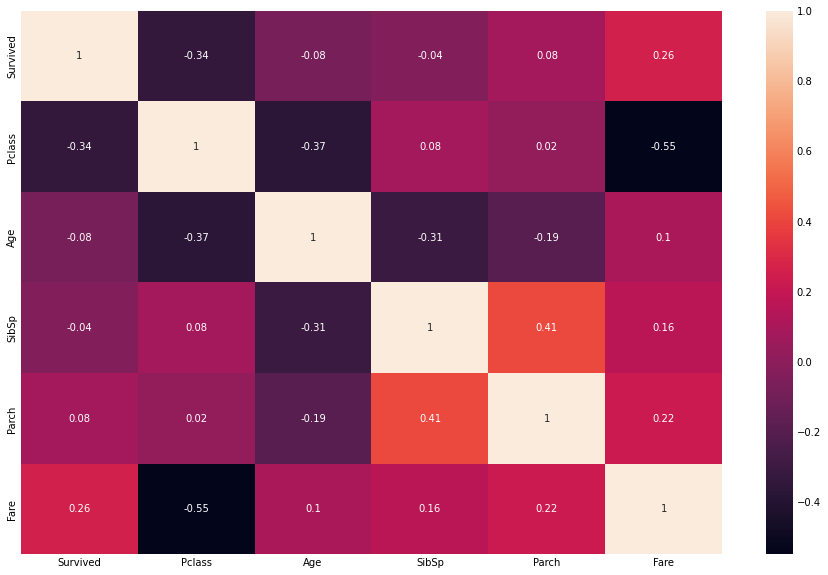

In [7]:
#correlation between all features
fig, ax = plt.subplots(figsize=(14,10))
matrix = train_df.corr().round(2)
sns.heatmap(matrix, annot=True)

At this point it is visible that there is no strong correlation of any particular feature 

### Survival vs Pclass

In [8]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], 
as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### Survival vs Age

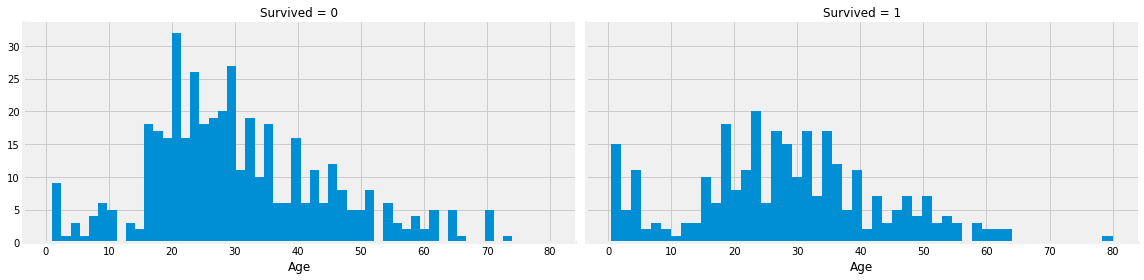

In [9]:
g = sns.FacetGrid(train_df, col='Survived', height=4, aspect=2)
g.map(plt.hist, 'Age', bins=50)

### Survival vs num of siblings

In [10]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'],
as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


### Survival vs Parch

In [11]:
train_df[["Parch", "Survived"]].groupby(['Parch'], 
as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### Survival vs Embarked

In [12]:
train_df[["Embarked", "Survived"]].groupby(['Embarked'], 
as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


### Correlating Numerical and Ordinal Features

Combine Age and Pclass

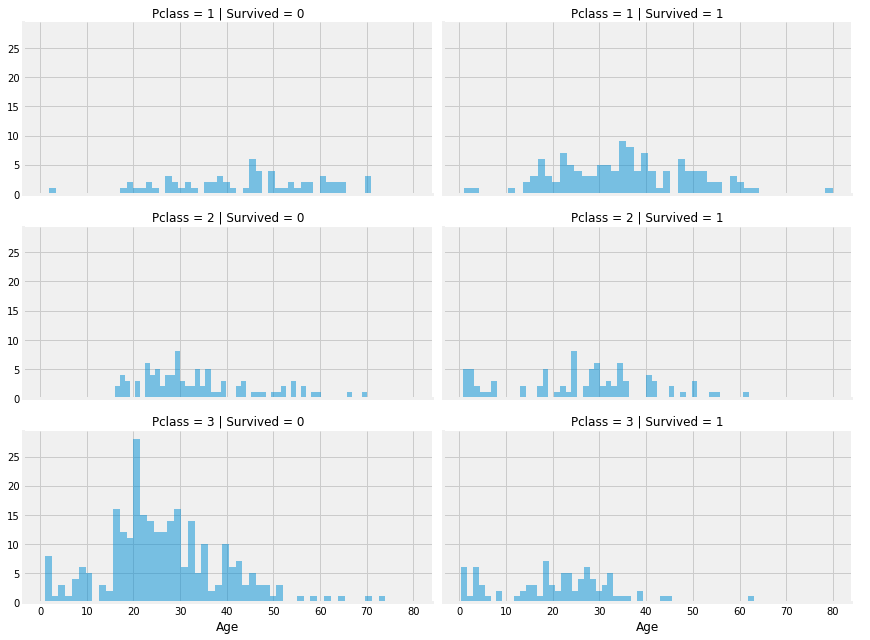

In [13]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=3, aspect=2)
grid.map(plt.hist, 'Age', alpha=.5, bins=50)
grid.add_legend();

## Data preprocessing

### Fill empty values

In [14]:
combine_df = [train_df, test_df]
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non

In [15]:
embarked_mode = train_df['Embarked'].mode()[0]
fare_mode = train_df['Fare'].mode()[0]

for df in combine_df:
    df['Embarked'].fillna(value= embarked_mode, inplace=True)
    df['Fare'].fillna(fare_mode, inplace=True)
    df['Cabin'].fillna('U', inplace=True)

combine_df[0].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S


### Encoding categorical values

In [16]:
#Encode Sex to numerical values
for df in combine_df:
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [17]:
# and Embarked with One Hote Encoding
combine_df[0] = pd.get_dummies(combine_df[0], columns=['Embarked'])
combine_df[1] = pd.get_dummies(combine_df[1], columns=['Embarked'])
    
combine_df[0].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U,0,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,38.0,1,0,PC 17599,71.2833,C85,1,0,0
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,0,1
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U,0,0,1


### Creating New Features Extracted from Existing - Titles from Name

In [18]:
for df in combine_df:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(combine_df[0]['Title'], combine_df[0]['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [19]:
for df in combine_df:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Sir', 'Mlle', 'Mme', 'Ms'], 'Nobility')
    df['Title'] = df['Title'].replace(['Capt', 'Don', 'Rev', 'Jonkheer'], 'Rare')
    df['Title'] = df['Title'].replace(['Col', 'Major', 'Dr', 'Master'], 'Honor')

combine_df[0][['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
4,Nobility,1.000000
3,Mrs,0.792000
1,Miss,0.697802
0,Honor,0.549020
2,Mr,0.156673
5,Rare,0.000000


In [20]:
title_mapping = {"Nobility": 6, "Mrs": 5, "Miss": 4, "Honor": 3, "Mr": 2, "Rare": 1}
for df in combine_df:
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(2.5) # value close to most common "Mr" (2) but higher as mean surviaval is higher

combine_df[0].head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Title
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U,0,0,1,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,38.0,1,0,PC 17599,71.2833,C85,1,0,0,5
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U,0,0,1,4
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,0,1,5
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U,0,0,1,2
6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,U,0,1,0,2
7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,0,0,1,2
8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,U,0,0,1,3
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,U,0,0,1,5


### Age - Replace NaN with mean age for group with same Sex, Pclass and Title

In [21]:
# Replace Age NaNs with mean age for group with same Sex, Pclass and Title
for df in combine_df:
    # group by Sex, Pclass, and Title 
    grouped = df.groupby(['Sex','Pclass', 'Title'])  
    # view the median Age by the grouped features 
    grouped.Age.median()
    # apply the grouped median value on the Age NaN
    df.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))
    df.Age.fillna(value=df['Age'].mean(), inplace=True) #replace left NaN with global mean

combine_df[0].info()
combine_df[1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Name        891 non-null    object 
 3   Sex         891 non-null    int32  
 4   Age         891 non-null    float64
 5   SibSp       891 non-null    int64  
 6   Parch       891 non-null    int64  
 7   Ticket      891 non-null    object 
 8   Fare        891 non-null    float64
 9   Cabin       891 non-null    object 
 10  Embarked_C  891 non-null    uint8  
 11  Embarked_Q  891 non-null    uint8  
 12  Embarked_S  891 non-null    uint8  
 13  Title       891 non-null    int64  
dtypes: float64(2), int32(1), int64(5), object(3), uint8(3)
memory usage: 82.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  --

c:\Users\Karol\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Cabin letter cause it represents physical location

In [22]:
# Fetch first letter from cabin number as it is indicator of physical location of cabin
combine_df[0].Cabin = combine_df[0].Cabin.map(lambda x: x[0])
# And now we can see how cabin letter corelates with survival
combine_df[0][["Cabin", "Survived"]].groupby(['Cabin']).mean().sort_values(by='Survived', ascending=False)

,Survived
Cabin,
D,0.757576
E,0.750000
B,0.744681
F,0.615385
C,0.593220
G,0.500000
A,0.466667
U,0.299854
T,0.000000


In [23]:
# Cabin map to number representing probability of surviving
cabin_mapping = {"D": 8, "E": 7, "B": 6, "F": 5, "C": 4, "G": 3, "A": 2, "U": 1, "T": 0}
for df in combine_df:
    df['Cabin'] = df['Cabin'].map(cabin_mapping)
    df['Cabin'] = df['Cabin'].fillna(1) # value for U

### Family size

In [24]:
for df in combine_df:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

combine_df[0][['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [25]:
# Map family size to number representing probability of surviving
for df in combine_df:
    df.loc[df['FamilySize'] == 4, 'Family'] = 7
    df.loc[df['FamilySize'] == 3, 'Family'] = 6
    df.loc[df['FamilySize'] == 2, 'Family'] = 5
    df.loc[df['FamilySize'] == 7, 'Family'] = 4
    df.loc[df['FamilySize'] == 1, 'Family'] = 3
    df.loc[df['FamilySize'] == 5, 'Family'] = 2
    df.loc[df['FamilySize'] == 6, 'Family'] = 1
    df.loc[df['FamilySize'] >= 8, 'Family'] = 0

In [26]:
#Drop unusable columns    
combine_df[0].drop(['Name', 'Ticket', 'FamilySize'], axis=1, inplace=True)
combine_df[1].drop(['Name', 'Ticket', 'FamilySize'], axis=1, inplace=True)
    
combine_df[0].head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Title,Family
PassengerId,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,1,0,0,1,2,5.0
2,1,1,1,38.0,1,0,71.2833,4,1,0,0,5,5.0
3,1,3,1,26.0,0,0,7.9250,1,0,0,1,4,3.0
4,1,1,1,35.0,1,0,53.1000,4,0,0,1,5,5.0
5,0,3,0,35.0,0,0,8.0500,1,0,0,1,2,3.0
6,0,3,0,26.0,0,0,8.4583,1,0,1,0,2,3.0
7,0,1,0,54.0,0,0,51.8625,7,0,0,1,2,3.0
8,0,3,0,2.0,3,1,21.0750,1,0,0,1,3,2.0
9,1,3,1,27.0,0,2,11.1333,1,0,0,1,5,6.0


### Lets see what correlations are now visible

<AxesSubplot:>

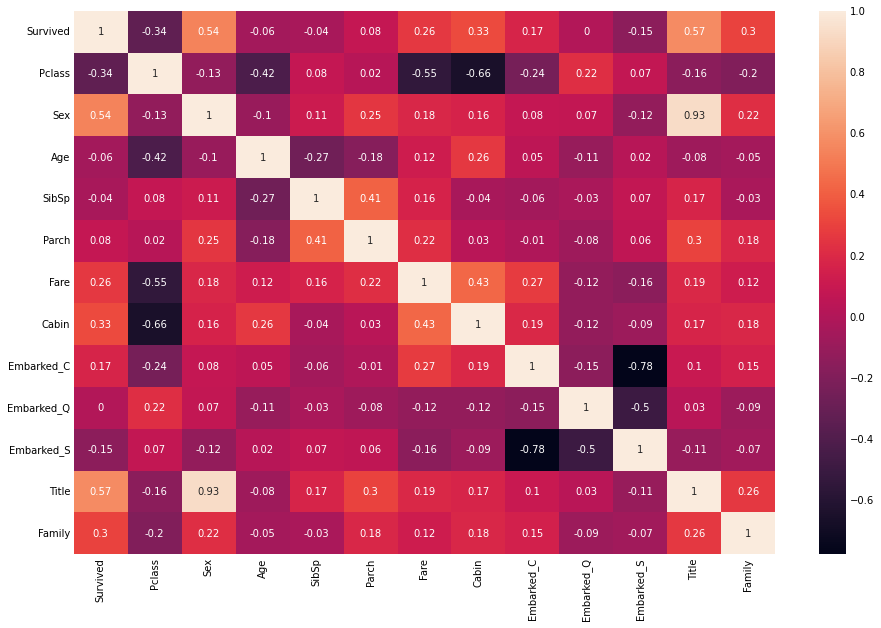

In [27]:
#correlation between all features
fig, ax = plt.subplots(figsize=(14,10))
matrix = combine_df[0].corr().round(2)
sns.heatmap(matrix, annot=True)

## Selecting predictive features

In [30]:
# extract only usable data
FEATURES= ['Age', 'Cabin', 'SibSp', 'Parch', 'Title', 'Fare', 'Sex', 'Family', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass']
TARGET = ['Survived']

combine_df[0][FEATURES+TARGET].head()

,Age,Cabin,SibSp,Parch,Title,Fare,Sex,Family,Embarked_C,Embarked_Q,Embarked_S,Pclass,Survived
PassengerId,,,,,,,,,,,,,
1,22.0,1,1,0,2,7.2500,0,5.0,0,0,1,3,0
2,38.0,4,1,0,5,71.2833,1,5.0,1,0,0,1,1
3,26.0,1,0,0,4,7.9250,1,3.0,0,0,1,3,1
4,35.0,4,1,0,5,53.1000,1,5.0,0,0,1,1,1
5,35.0,1,0,0,2,8.0500,0,3.0,0,0,1,3,0


## Normalize with StandardScaler

In [31]:
scaler = StandardScaler()
FEATURES_FOR_SCALING = ['Age', 'Cabin', 'SibSp', 'Parch', 'Title', 'Fare', 'Family', 'Pclass']

final_test_df = combine_df[1].copy()
final_test_df[FEATURES_FOR_SCALING] = scaler.fit_transform(final_test_df[FEATURES_FOR_SCALING])
final_train_df = combine_df[0].copy()
final_train_df[FEATURES_FOR_SCALING] = scaler.fit_transform(final_train_df[FEATURES_FOR_SCALING])
final_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Title,Family
PassengerId,,,,,,,,,,,,,
1,0,0.827377,0,-0.529642,0.432793,-0.473674,-0.502445,-0.494813,0,0,1,-0.754464,0.894514
2,1,-1.566107,1,0.656498,0.432793,-0.473674,0.786845,0.960231,1,0,0,1.738345,0.894514
3,1,0.827377,1,-0.233107,-0.474545,-0.473674,-0.488854,-0.494813,0,0,1,0.907408,-0.523657
4,1,-1.566107,1,0.434097,0.432793,-0.473674,0.420730,0.960231,0,0,1,1.738345,0.894514
5,0,0.827377,0,0.434097,-0.474545,-0.473674,-0.486337,-0.494813,0,0,1,-0.754464,-0.523657


# Modeling

## Random forest with grid search

As it turns out best model for the task

In [32]:
x, y = final_train_df[FEATURES], final_train_df[TARGET]['Survived'].values

# create param grid object 
forrest_params = dict(     
    max_depth = [n for n in range(9, 14)],     
    min_samples_split = [n for n in range(5, 13)], 
    min_samples_leaf = [n for n in range(1, 5)],     
    n_estimators = [n for n in range(200, 700, 50)],
)
# Grid Search for best params
# forrest = RandomForestClassifier()
# forest_cv = GridSearchCV(estimator=forrest, param_grid=forrest_params, cv=5)
# forest_cv.fit(x, y)
# print("Best score: {}".format(forest_cv.best_score_))
# print("Optimal params: {}".format(forest_cv.best_estimator_))

#Params for best score: 0.8038277511961722:
forrest = RandomForestClassifier(max_depth=13, min_samples_split=9, n_estimators=550, random_state=46)
forrest.fit(x, y)


RandomForestClassifier(max_depth=13, min_samples_split=9, n_estimators=550,
                       random_state=46)

In [33]:
predictions = forrest.predict(final_test_df[FEATURES])

submission = pd.read_csv('data/gender_submission.csv')
submission['Survived'] = predictions
submission.to_csv('submission.csv', index=False)